In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Download the photo

In [3]:
dataset_path = r'F:\Helwan DS\intro ML\project\fruits-360_100x100\fruits-360\Training'

CLASSES = ['Apple Red 1', 'Banana 1', 'Cherry 1', 'Kiwi 1', 'Orange 1']
images = []
labels = []
valid_ext = ('.jpg', '.jpeg', '.png')


# preprocessing

In [4]:
for class_idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(dataset_path, class_name)

    for img_name in sorted(os.listdir(class_path)):
        if not img_name.lower().endswith(valid_ext):
            continue

        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        # Skip unreadable files
        if img is None:
            continue

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     # Convert to grayscale
        img_resized = cv2.resize(img_gray, (100, 100))       # Resize to 100x100

        images.append(img_resized.flatten())
        labels.append(class_idx)

# Convert lists to numpy arrays + normalize
X = np.array(images, dtype=np.float32) / 255.0   
y = np.array(labels, dtype=np.int32)

print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))


Dataset shape: (2419, 10000), Labels shape: (2419,)
Class counts: {np.int32(0): np.int64(492), np.int32(1): np.int64(490), np.int32(2): np.int64(492), np.int32(3): np.int64(466), np.int32(4): np.int64(479)}


# Train-test split


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1935, 10000) Test: (484, 10000)


# PCA

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original features:", X_train.shape[1])
print("Reduced features:", X_train_pca.shape[1])


Original features: 10000
Reduced features: 137


# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Logistic Regression
log_reg_pca = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",
    random_state=42
)

# Train
log_reg_pca.fit(X_train_pca, y_train)

# Predict
y_pred_pca = log_reg_pca.predict(X_test_pca)

# Evaluate
print("Logistic Regression (with PCA) Accuracy:",
      accuracy_score(y_test, y_pred_pca))

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_pca))

print("\nConfusion Matrix:\n",
      confusion_matrix(y_test, y_pred_pca))


Logistic Regression (with PCA) Accuracy: 0.9979338842975206

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      0.99      0.99        98
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00        93
           4       0.99      1.00      0.99        96

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484


Confusion Matrix:
 [[99  0  0  0  0]
 [ 0 97  0  0  1]
 [ 0  0 98  0  0]
 [ 0  0  0 93  0]
 [ 0  0  0  0 96]]


# K means

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=10
)

clusters = kmeans.fit_predict(X_train_pca)

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_train_pca, clusters)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.2832564115524292


# Visualization

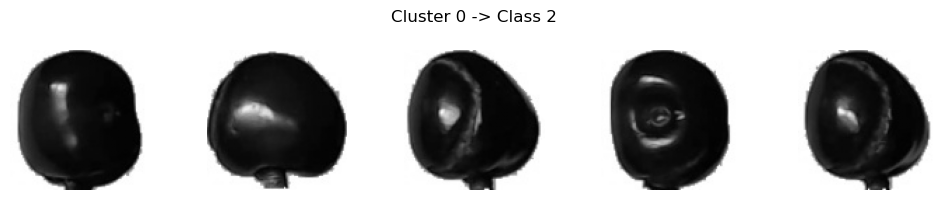

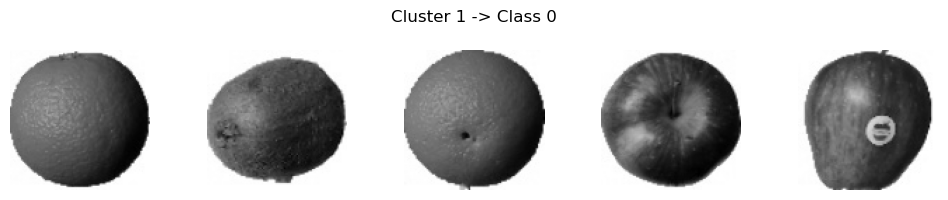

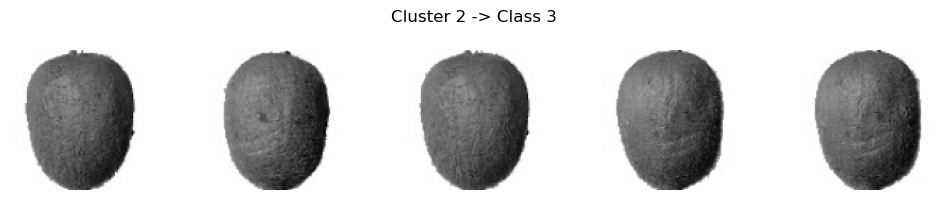

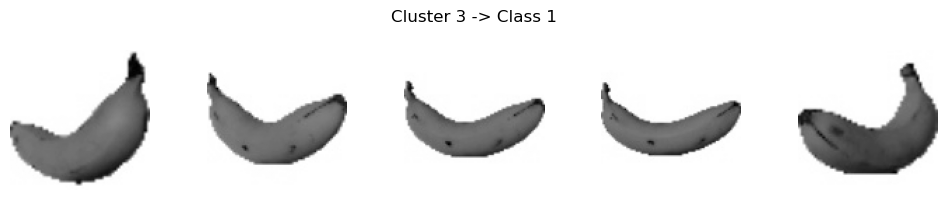

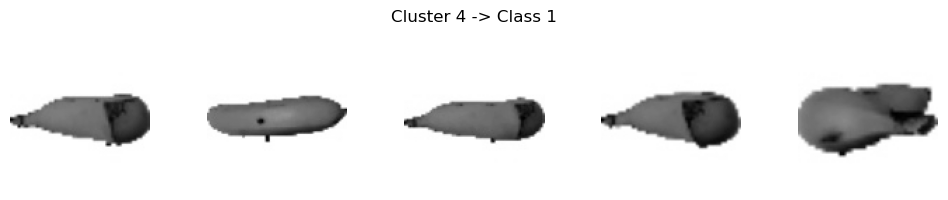

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode


train_clusters = kmeans.predict(X_train_pca)
k = kmeans.n_clusters

cluster_to_class = {}
for c in range(k):
    idx = np.where(train_clusters == c)[0]
    if len(idx) == 0:
        cluster_to_class[c] = None
    else:
        cluster_to_class[c] = int(mode(y_train[idx], keepdims=True).mode[0])

np.random.seed(42)

for c in range(k):
    idx = np.where(train_clusters == c)[0]

    if len(idx) == 0:
        print(f"Cluster {c} is empty.")
        continue

    sample_size = min(5, len(idx))
    sample_idx = np.random.choice(idx, size=sample_size, replace=False)

    plt.figure(figsize=(10, 2))
    mapped_class = cluster_to_class[c]
    title = f"Cluster {c} -> Class {mapped_class}" if mapped_class is not None else f"Cluster {c} -> Class ?"
    plt.suptitle(title)

    for i, s in enumerate(sample_idx):
        img_vec = X_train[s]                 # raw flattened image used for display
        img = img_vec.reshape(100, 100)      # grayscale 100x100

        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Testing

Predicted class: Cherry 1


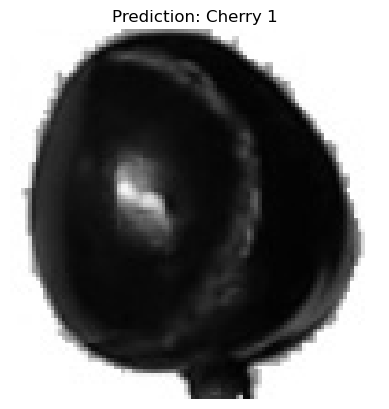

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_path = r"F:\Helwan DS\intro ML\project\fruits-360_100x100\fruits-360\Test\Cherry 1\4_100.jpg"

# Read image
img = cv2.imread(img_path)
if img is None:
    raise ValueError("Image not found or path is incorrect")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (100, 100))

# Prepare image (same preprocessing as training)
img_flat = img_resized.flatten().reshape(1, -1).astype(np.float32) / 255.0
img_scaled = scaler.transform(img_flat)
img_pca = pca.transform(img_scaled)

# Predict
pred_class = log_reg_pca.predict(img_pca)[0]
pred_name = CLASSES[pred_class]

print("Predicted class:", pred_name)

# Show image
plt.imshow(img_resized, cmap='gray')
plt.title(f"Prediction: {pred_name}")
plt.axis('off')
plt.show()
